## Working with Transformers in the HuggingFace Ecosystem

In this laboratory exercise we will learn how to work with the HuggingFace ecosystem to adapt models to new tasks. As you will see, much of what is required is *investigation* into the inner-workings of the HuggingFace abstractions. With a little work, a little trial-and-error, it is fairly easy to get a working adaptation pipeline up and running.

### Exercise 1: Sentiment Analysis (warm up)

In this first exercise we will start from a pre-trained BERT transformer and build up a model able to perform text sentiment analysis. Transformers are complex beasts, so we will build up our pipeline in several explorative and incremental steps.

#### Exercise 1.1: Dataset Splits and Pre-trained model
There are a many sentiment analysis datasets, but we will use one of the smallest ones available: the [Cornell Rotten Tomatoes movie review dataset](cornell-movie-review-data/rotten_tomatoes), which consists of 5,331 positive and 5,331 negative processed sentences from the Rotten Tomatoes movie reviews.

**Your first task**: Load the dataset and figure out what splits are available and how to get them. Spend some time exploring the dataset to see how it is organized. Note that we will be using the [HuggingFace Datasets](https://huggingface.co/docs/datasets/en/index) library for downloading, accessing, splitting, and batching data for training and evaluation.

In [1]:
import wandb

In [2]:
from datasets import load_dataset, get_dataset_split_names

dataset = load_dataset("rotten_tomatoes")


/andromeda/personal/mpiras/miniconda3/envs/TRANSFORMERS/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Figure out what splits are available and how to get them
split_names = get_dataset_split_names("rotten_tomatoes")
print("Available splits:", split_names)

Available splits: ['train', 'validation', 'test']


In [4]:
# Explore the dataset
print("\nDataset structure:")
print(dataset)


Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})


In [5]:
print("\nAccessing a split (train):")
train_split = dataset["train"]
print(train_split)


Accessing a split (train):
Dataset({
    features: ['text', 'label'],
    num_rows: 8530
})


In [6]:
print("\nExploring a sample from the train split:")
print(train_split[0])


Exploring a sample from the train split:
{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}


In [7]:
print("\nFeatures in the train split:")
print(train_split.features)


Features in the train split:
{'text': Value('string'), 'label': ClassLabel(names=['neg', 'pos'])}


#### Exercise 1.2: A Pre-trained BERT and Tokenizer

The model we will use is a *very* small BERT transformer called [Distilbert](https://huggingface.co/distilbert/distilbert-base-uncased) this model was trained (using self-supervised learning) on the same corpus as BERT but using the full BERT base model as a *teacher*.

**Your next task**: Load the Distilbert model and corresponding tokenizer. Use the tokenizer on a few samples from the dataset and pass the tokens through the model to see what outputs are provided. I suggest you use the [`AutoModel`](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html) class (and the `from_pretrained()` method) to load the model and `AutoTokenizer` to load the tokenizer).

In [8]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load the Distilbert model and tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [9]:
# Use the tokenizer on a few samples from the dataset
# Assuming 'dataset' with a 'train' split is available from the previous step
sample_texts = [dataset["train"][i]["text"] for i in range(3)]
tokenized_inputs = tokenizer(sample_texts, padding=True, truncation=True, return_tensors="pt")

print("\nSample texts:")
for text in sample_texts:
    print(text)

print("\nTokenized inputs:")
print(tokenized_inputs)


Sample texts:
the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .
the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .
effective but too-tepid biopic

Tokenized inputs:
{'input_ids': tensor([[  101,  1996,  2600,  2003, 16036,  2000,  2022,  1996,  7398,  2301,
          1005,  1055,  2047,  1000, 16608,  1000,  1998,  2008,  2002,  1005,
          1055,  2183,  2000,  2191,  1037, 17624,  2130,  3618,  2084,  7779,
         29058,  8625, 13327,  1010,  3744,  1011, 18856, 19513,  3158,  5477,
          4168,  2030,  7112, 16562,  2140,  1012,   102,     0,     0,     0,
             0,     0],
        [  101,  1996,  9882,  2135,  9603, 13633,  1997,  1000,  1996,  2935,
          1997,  1

In [10]:
# Pass the tokens through the model
with torch.no_grad():  # Disable gradient calculation for inference
    outputs = model(**tokenized_inputs)

print("\nModel outputs:")
print(outputs)


Model outputs:
BaseModelOutput(last_hidden_state=tensor([[[-0.0332, -0.0168,  0.0194,  ...,  0.0476,  0.5834,  0.3036],
         [-0.0235, -0.0555, -0.3638,  ...,  0.1877,  0.5781, -0.1577],
         [-0.0516, -0.1014, -0.1511,  ...,  0.1503,  0.2649, -0.1575],
         ...,
         [ 0.3688, -0.1147,  0.8428,  ..., -0.0708, -0.0178, -0.2516],
         [ 0.0654, -0.0206,  0.1889,  ...,  0.1159,  0.2323, -0.2404],
         [ 0.0373, -0.0104,  0.1203,  ...,  0.1049,  0.2852, -0.3035]],

        [[-0.2062, -0.0490, -0.4036,  ..., -0.1186,  0.6141,  0.3919],
         [-0.4361, -0.1647, -0.3533,  ...,  0.1086,  0.9478, -0.0272],
         [-0.1164,  0.1690,  0.2698,  ..., -0.1971,  0.4372,  0.2527],
         ...,
         [-0.2341,  0.4810, -0.2634,  ..., -0.3397,  0.2567,  0.1274],
         [ 0.7139,  0.0574, -0.3260,  ...,  0.2041, -0.3800, -0.3343],
         [ 0.5649,  0.2806, -0.0295,  ...,  0.1297, -0.3160, -0.1874]],

        [[-0.2706, -0.1265, -0.0500,  ..., -0.3721,  0.2477,  0.33

In [11]:
# The 'last_hidden_state' contains the sequence of hidden states for each token
print("\nLast hidden state shape:", outputs.last_hidden_state.shape)


Last hidden state shape: torch.Size([3, 52, 768])


In [12]:
# The '[CLS]' token representation is typically the first token
cls_representation = outputs.last_hidden_state[:, 0, :]
print("\n[CLS] token representation shape:", cls_representation.shape)


[CLS] token representation shape: torch.Size([3, 768])


#### Exercise 1.3: A Stable Baseline

In this exercise I want you to:
1. Use Distilbert as a *feature extractor* to extract representations of the text strings from the dataset splits;
2. Train a classifier (your choice, by an SVM from Scikit-learn is an easy choice).
3. Evaluate performance on the validation and test splits.

These results are our *stable baseline* -- the **starting** point on which we will (hopefully) improve in the next exercise.

**Hint**: There are a number of ways to implement the feature extractor, but probably the best is to use a [feature extraction `pipeline`](https://huggingface.co/tasks/feature-extraction). You will need to interpret the output of the pipeline and extract only the `[CLS]` token from the *last* transformer layer. *How can you figure out which output that is?*

In [13]:
from transformers import pipeline
import numpy as np

# Create a feature extraction pipeline
feature_extractor = pipeline("feature-extraction", model="distilbert-base-uncased", device=0 if torch.cuda.is_available() else -1)

Device set to use cuda:0


In [14]:
# Define a function to extract CLS token embeddings
def extract_cls_embedding(batch):
    # The pipeline returns a list of lists of lists (batch, sequence, embedding)
    # We want the embedding of the first token ([CLS]) for each example in the batch
    features = feature_extractor(batch["text"])
    # Extract the [CLS] token embedding (index 0) from the last layer
    cls_embeddings = [feature[0][0] for feature in features]
    return {"cls_embedding": cls_embeddings}

In [15]:
# Apply the feature extraction function to each split
# Use batched=True for efficiency
train_dataset_with_features = dataset["train"].map(extract_cls_embedding, batched=True, batch_size=16)
validation_dataset_with_features = dataset["validation"].map(extract_cls_embedding, batched=True, batch_size=16)
test_dataset_with_features = dataset["test"].map(extract_cls_embedding, batched=True, batch_size=16)
print("\nTrain dataset with CLS embeddings:")
print(train_dataset_with_features[0])


Train dataset with CLS embeddings:
{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1, 'cls_embedding': [-0.033173568546772, -0.01680893637239933, 0.01941203698515892, -0.025717880576848984, -0.1379668116569519, -0.396170437335968, 0.38299688696861267, 0.5117568373680115, 0.023082178086042404, -0.055535245686769485, -0.06316477060317993, -0.1368159055709839, -0.051797766238451004, 0.49828872084617615, 0.23182572424411774, 0.23795589804649353, -0.3116884231567383, 0.2472486048936844, 0.2279399335384369, 0.04644637554883957, -0.1539628505706787, -0.15128518640995026, 0.17389161884784698, -0.07235707342624664, 0.05871446803212166, -0.1852138340473175, -0.0366290844976902, -0.06726163625717163, 0.08163899183273315, 0.2598537504673004, 0.023714572191238403, 0.07896119356155396, -0.5168825387954712, -0.29590749740600586, 0.04539728909730911,

In [16]:
# Remove the original 'text' column
train_dataset_with_features = train_dataset_with_features.remove_columns("text")
validation_dataset_with_features = validation_dataset_with_features.remove_columns("text")
test_dataset_with_features = test_dataset_with_features.remove_columns("text")

In [17]:
# Display the structure of the new datasets
print("\nTrain dataset with features:")
print(train_dataset_with_features)
print("\nValidation dataset with features:")
print(validation_dataset_with_features)
print("\nTest dataset with features:")
print(test_dataset_with_features)

# Display a sample from the train dataset with features
print("\nSample from train dataset with features:")
print(train_dataset_with_features[0])


Train dataset with features:
Dataset({
    features: ['label', 'cls_embedding'],
    num_rows: 8530
})

Validation dataset with features:
Dataset({
    features: ['label', 'cls_embedding'],
    num_rows: 1066
})

Test dataset with features:
Dataset({
    features: ['label', 'cls_embedding'],
    num_rows: 1066
})

Sample from train dataset with features:
{'label': 1, 'cls_embedding': [-0.033173568546772, -0.01680893637239933, 0.01941203698515892, -0.025717880576848984, -0.1379668116569519, -0.396170437335968, 0.38299688696861267, 0.5117568373680115, 0.023082178086042404, -0.055535245686769485, -0.06316477060317993, -0.1368159055709839, -0.051797766238451004, 0.49828872084617615, 0.23182572424411774, 0.23795589804649353, -0.3116884231567383, 0.2472486048936844, 0.2279399335384369, 0.04644637554883957, -0.1539628505706787, -0.15128518640995026, 0.17389161884784698, -0.07235707342624664, 0.05871446803212166, -0.1852138340473175, -0.0366290844976902, -0.06726163625717163, 0.08163899183273

In [18]:
# Access 'cls_embedding' and 'label' columns and convert to NumPy arrays
X_train = np.array(train_dataset_with_features["cls_embedding"])
y_train = np.array(train_dataset_with_features["label"])

X_val = np.array(validation_dataset_with_features["cls_embedding"])
y_val = np.array(validation_dataset_with_features["label"])

X_test = np.array(test_dataset_with_features["cls_embedding"])
y_test = np.array(test_dataset_with_features["label"])

# Print the shapes of the resulting NumPy arrays
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (8530, 768)
Shape of y_train: (8530,)
Shape of X_val: (1066, 768)
Shape of y_val: (1066,)
Shape of X_test: (1066, 768)
Shape of y_test: (1066,)


In [19]:
from sklearn.svm import SVC

# Instantiate the SVC classifier with default parameters
svm_classifier = SVC()

# Train the classifier using the training data
svm_classifier.fit(X_train, y_train)

print("SVM classifier training complete.")

SVM classifier training complete.


In [ ]:
from sklearn.metrics import accuracy_score

wandb.init(project="Lab-3", name="rotten_tomatoes_distillbert_baseline_svm")
# Make predictions on the validation set
y_val_pred = svm_classifier.predict(X_val)

# Calculate accuracy on the validation set
validation_accuracy = accuracy_score(y_val, y_val_pred)

# Make predictions on the test set
y_test_pred = svm_classifier.predict(X_test)

# Calculate accuracy on the test set
baseline_test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the accuracies
print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Test Accuracy: {baseline_test_accuracy:.4f}")

wandb.log({
    "baseline/validation_accuracy": validation_accuracy,
    "baseline/test_accuracy": baseline_test_accuracy,
})
wandb.finish()

wandb: Currently logged in as: matteo-piras (matteo-piras-universit-di-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Validation Accuracy: 0.8143
Test Accuracy: 0.7946


baseline/test_accuracy,▁
baseline/validation_accuracy,▁
baseline/test_accuracy,0.79456
baseline/validation_accuracy,0.81426


-----
### Exercise 2: Fine-tuning Distilbert

In this exercise we will fine-tune the Distilbert model to (hopefully) improve sentiment analysis performance.

#### Exercise 2.1: Token Preprocessing

The first thing we need to do is *tokenize* our dataset splits. Our current datasets return a dictionary with *strings*, but we want *input token ids* (i.e. the output of the tokenizer). This is easy enough to do my hand, but the HugginFace `Dataset` class provides convenient, efficient, and *lazy* methods. See the documentation for [`Dataset.map`](https://huggingface.co/docs/datasets/v3.5.0/en/package_reference/main_classes#datasets.Dataset.map).

**Tip**: Verify that your new datasets are returning for every element: `text`, `label`, `intput_ids`, and `attention_mask`.

In [21]:
# Assuming 'dataset' and 'tokenizer' are available from previous steps

def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

# Apply the tokenizer to each split of the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Verify the new datasets have the expected columns
print("\nTokenized datasets structure:")
print(tokenized_datasets)

print("\nSample from tokenized train split:")
print(tokenized_datasets["train"][0])


Tokenized datasets structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1066
    })
})

Sample from tokenized train split:
{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1, 'input_ids': [101, 1996, 2600, 2003, 16036, 2000, 2022, 1996, 7398, 2301, 1005, 1055, 2047, 1000, 16608, 1000, 1998, 2008, 2002, 1005, 1055, 2183, 2000, 2191, 1037, 17624, 2130, 3618, 2084, 7779, 29058, 8625, 13327, 1010, 3744, 1011, 18856, 19513, 3158, 5477, 4168, 2030, 7112, 16562, 2140, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

#### Exercise 2.2: Setting up the Model to be Fine-tuned

In this exercise we need to prepare the base Distilbert model for fine-tuning for a *sequence classification task*. This means, at the very least, appending a new, randomly-initialized classification head connected to the `[CLS]` token of the last transformer layer. Luckily, HuggingFace already provides an `AutoModel` for just this type of instantiation: [`AutoModelForSequenceClassification`](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#automodelforsequenceclassification). You will want you instantiate one of these for fine-tuning.

In [22]:
from transformers import AutoModelForSequenceClassification

model_full = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

print("\nModel with classification head:")
print(model)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model with classification head:
DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=307

#### Exercise 2.3: Fine-tuning Distilbert

Finally. In this exercise you should use a HuggingFace [`Trainer`](https://huggingface.co/docs/transformers/main/en/trainer) to fine-tune your model on the Rotten Tomatoes training split. Setting up the trainer will involve (at least):


1. Instantiating a [`DataCollatorWithPadding`](https://huggingface.co/docs/transformers/en/main_classes/data_collator) object which is what *actually* does your batch construction (by padding all sequences to the same length).
2. Writing an *evaluation function* that will measure the classification accuracy. This function takes a single argument which is a tuple containing `(logits, labels)` which you should use to compute classification accuracy (and maybe other metrics like F1 score, precision, recall) and return a `dict` with these metrics.  
3. Instantiating a [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.51.1/en/main_classes/trainer#transformers.TrainingArguments) object using some reasonable defaults.
4. Instantiating a `Trainer` object using your train and validation splits, you data collator, and function to compute performance metrics.
5. Calling `trainer.train()`, waiting, waiting some more, and then calling `trainer.evaluate()` to see how it did.

**Tip**: When prototyping this laboratory I discovered the HuggingFace [Evaluate library](https://huggingface.co/docs/evaluate/en/index) which provides evaluation metrics. However I found it to have insufferable layers of abstraction and getting actual metrics computed. I suggest just using the Scikit-learn metrics...

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

# Assuming 'model' and 'tokenized_datasets' are available from previous steps

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

In [25]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def get_trainer(model, run_name, learning_rate=5e-5):
    training_args = TrainingArguments(
        output_dir=f"./results/{run_name}",
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        logging_strategy="epoch",
        num_train_epochs=10,
        per_device_train_batch_size=16, 
        per_device_eval_batch_size=16,  
        learning_rate=learning_rate,
        weight_decay=0.01,
        save_total_limit=1,
        fp16=True,               # if GPU
        report_to="wandb",
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        data_collator=data_collator,         
        compute_metrics=compute_metrics,     
    )
    
    return trainer

In [27]:
from transformers import AutoModelForSequenceClassification
import time

wandb.init(project="Lab-3", name="Distillerbert Full Fine-Tuning")
trainer_full = get_trainer(model_full, "full_ft")
start = time.time()
trainer_full.train()
end = time.time()
metrics_full = trainer_full.evaluate()
metrics_full["trainable_params"] = count_trainable_params(model_full)
metrics_full["train_time_sec"] = end - start
metrics_full["train_time_min"] = (end - start) / 60
wandb.log({
    "test/accuracy": metrics_full["eval_accuracy"],
    "test/trainable_params": metrics_full["trainable_params"],
    "test/log_10_trainable_params": np.log10(metrics_full["trainable_params"]),
    "test/train_time_min": metrics_full["train_time_min"],
})
wandb.finish()

/andromeda/personal/mpiras/miniconda3/envs/TRANSFORMERS/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.413100,0.394794,0.822702,0.820309,0.840854,0.822702
2,0.210900,0.383659,0.848030,0.847771,0.850418,0.848030
3,0.101300,0.530845,0.842402,0.841965,0.846223,0.842402
4,0.047000,0.664062,0.850844,0.850838,0.850905,0.850844
5,0.027700,0.870928,0.846154,0.845787,0.849480,0.846154
6,0.013100,0.880806,0.858349,0.858328,0.858562,0.858349
7,0.009900,1.023328,0.846154,0.846048,0.847112,0.846154
8,0.005100,1.024341,0.848968,0.848946,0.849176,0.848968
9,0.004800,1.059933,0.847092,0.847053,0.847445,0.847092
10,0.002000,1.066640,0.850844,0.850838,0.850905,0.850844


/andromeda/personal/mpiras/miniconda3/envs/TRANSFORMERS/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/andromeda/personal/mpiras/miniconda3/envs/TRANSFORMERS/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/andromeda/personal/mpiras/miniconda3/envs/TRANSFORMERS/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/andromeda/personal/mpiras/miniconda3/envs/TRANSFORMERS/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input ten

eval/accuracy,▁▆▅▇▆█▆▆▆▇█
eval/f1,▁▆▅▇▆█▆▆▆▇█
eval/loss,▁▁▃▄▆▆████▆
eval/precision,▁▅▃▅▄█▃▄▄▅█
eval/recall,▁▆▅▇▆█▆▆▆▇█
eval/runtime,▂▁█▁▁▁▂▁▁▂▃
eval/samples_per_second,▇█▁███▇▇█▇▆
eval/steps_per_second,▇█▁███▇▇█▇▆
test/accuracy,▁
test/log_10_trainable_params,▁
+7,...


-----
### Exercise 3: Choose at Least One


#### Exercise 3.1: Efficient Fine-tuning for Sentiment Analysis (easy)

In Exercise 2 we fine-tuned the *entire* Distilbert model on Rotten Tomatoes. This is expensive, even for a small model. Find an *efficient* way to fine-tune Distilbert on the Rotten Tomatoes dataset (or some other dataset).

**Hint**: You could check out the [HuggingFace PEFT library](https://huggingface.co/docs/peft/en/index) for some state-of-the-art approaches that should "just work". How else might you go about making fine-tuning more efficient without having to change your training pipeline from above?

#### Partial Fine-Tuning
The simplest approach is to partially fine-tune the model. In this setting, only the last two layers (the final encoder layer and the classification head) are unfrozen and updated during training. This strategy is expected to result in lower performance compared to full fine-tuning, but with significantly faster training.

In [ ]:
model_partial = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

# Freeze all backbone
for param in model_partial.distilbert.parameters():
    param.requires_grad = False

# Unfreeze last encoder layer
for param in model_partial.distilbert.transformer.layer[-1].parameters():
    param.requires_grad = True

# Keep classifier trainable (default)
for param in model_partial.classifier.parameters():
    param.requires_grad = True

wandb.init(project="Lab-3", name="Distillerbert Partial Fine-Tuning")
trainer_partial = get_trainer(model_partial, "partial_ft")
start = time.time()
trainer_partial.train()
end = time.time()
metrics_partial = trainer_partial.evaluate()
metrics_partial["trainable_params"] = count_trainable_params(model_partial)
metrics_partial["train_time_sec"] = end - start
metrics_partial["train_time_min"] = (end - start) / 60
wandb.log({
    "test/accuracy": metrics_partial["eval_accuracy"],
    "test/trainable_params": metrics_partial["trainable_params"],
    "test/log_10_trainable_params": np.log10(metrics_partial["trainable_params"]),
    "test/train_time_min": metrics_partial["train_time_min"],
})
wandb.finish()

#### LoRA Fine-Tuning
The Parameter-Efficient Fine-Tuning (PEFT) method explored in this laboratory is LoRA. This approach is expected to achieve better performance than partial fine-tuning while maintaining a significantly lower fine-tuning time compared to full fine-tuning. LoRA enables the adaptation of a larger portion of the network by introducing a small number of trainable low-rank parameters, thereby keeping the total number of fine-tuned parameters low.

Since LoRA supports multiple configuration choices, several setups are explored in this work, loosely inspired by the configurations proposed in the original LoRA paper.

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType

lora_results = {}
lora_configs = {
    "lora_r8_qv": {
        "r": 8,
        "alpha": 16,
        "dropout": 0.1,
        "target_modules": ["q_lin", "v_lin"]
    },
    "lora_r8_qkvo": {
        "r": 8,
        "alpha": 16,
        "dropout": 0.1,
        "target_modules": ["q_lin", "k_lin", "v_lin", "out_lin"]
    },
    "lora_r8_full": {
        "r": 8,
        "alpha": 16,
        "dropout": 0.1,
        "target_modules": ["q_lin", "k_lin", "v_lin", "out_lin", "ffn.lin1", "ffn.lin2"]
    },
    "lora_r16_qv": {
        "r": 16,
        "alpha": 32,
        "dropout": 0.1,
        "target_modules": ["q_lin", "v_lin"]
    },
    "lora_r16_qkvo": {
        "r": 16,
        "alpha": 32,
        "dropout": 0.1,
        "target_modules": ["q_lin", "k_lin", "v_lin", "out_lin"]
    },
    "lora_r16_full": {
        "r": 16,
        "alpha": 32,
        "dropout": 0.1,
        "target_modules": ["q_lin", "k_lin", "v_lin", "out_lin", "ffn.lin1", "ffn.lin2"]
    },
    "lora_r32_full": {
        "r": 32,
        "alpha": 64,
        "dropout": 0.15,
        "target_modules": ["q_lin", "k_lin", "v_lin", "out_lin", "ffn.lin1", "ffn.lin2"]
    },
}

for name, cfg in lora_configs.items():

    base_model = AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", num_labels=2
    )

    lora_config = LoraConfig(
        r=cfg["r"],
        lora_alpha=cfg["alpha"],
        lora_dropout=cfg["dropout"],
        bias="none",
        task_type=TaskType.SEQ_CLS,
        target_modules=cfg["target_modules"]
    )

    model_lora = get_peft_model(base_model, lora_config)

    wandb.init(project="Lab-3", name=f"Distillerbert {name} LoRA Fine-Tuning")
    trainer = get_trainer(model_lora, name)
    start = time.time()
    trainer.train()
    end = time.time()

    metrics = trainer.evaluate()
    metrics["trainable_params"] = count_trainable_params(model_lora)
    metrics["train_time_sec"] = end - start
    metrics["train_time_min"] = (end - start) / 60
    wandb.log({
    "test/accuracy": metrics["eval_accuracy"],
    "test/trainable_params": metrics["trainable_params"],
    "test/log_10_trainable_params": np.log10(metrics["trainable_params"]),
    "test/train_time_min": metrics["train_time_min"],
    })
    wandb.finish()
    lora_results[name] = metrics


In [30]:
import pandas as pd

df_results = pd.DataFrame({
    "Full-FT": metrics_full,
    "Partial-FT": metrics_partial,
    **lora_results
})
# Transpose so models are rows
df_results = df_results.T

# Now compute log10
df_results["log10_trainable_params"] = np.log10(df_results["trainable_params"])

# Reorder columns if needed
df_results = df_results[["eval_accuracy", "eval_loss", "train_time_min", "trainable_params", "log10_trainable_params"]]

df_results

,eval_accuracy,eval_loss,train_time_min,trainable_params,log10_trainable_params
Full-FT,0.858349,0.880806,9.610543,66955010.0,7.825783
Partial-FT,0.848968,0.350226,7.537965,7680002.0,6.885361
lora_r8_qv,0.837711,0.364240,8.037850,739586.0,5.868989
lora_r8_qkvo,0.845216,0.345506,8.969261,887042.0,5.947944
lora_r8_full,0.850844,0.348844,9.832779,1255682.0,6.098880
lora_r16_qv,0.846154,0.350420,8.020746,887042.0,5.947944
lora_r16_qkvo,0.849906,0.345366,8.910883,1181954.0,6.072601
lora_r16_full,0.852720,0.365769,11.088894,1919234.0,6.283128
lora_r32_full,0.850844,0.387347,14.493478,3246338.0,6.511394


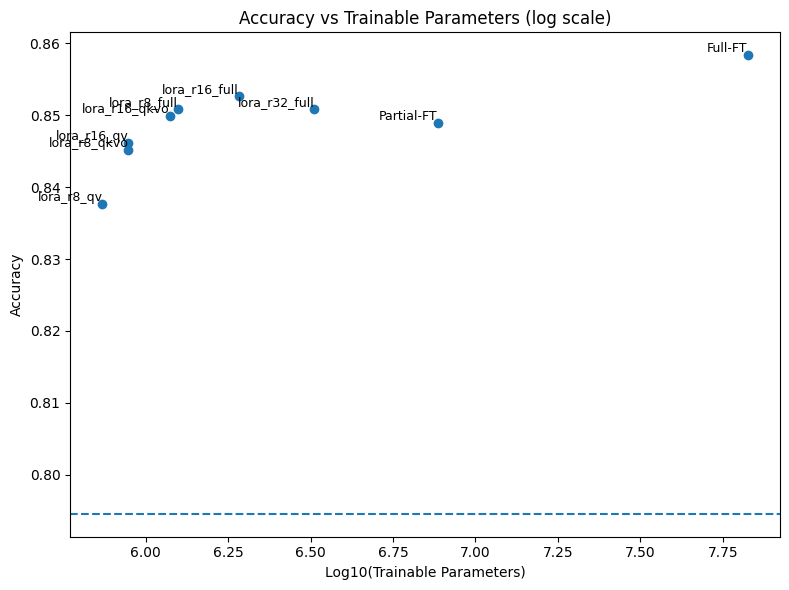

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_results["log10_trainable_params"], df_results["eval_accuracy"])
plt.xlabel("Log10(Trainable Parameters)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Trainable Parameters (log scale)")

# Add horizontal stable baseline line
plt.axhline(y=baseline_test_accuracy, linestyle='--')

# Annotate each point with model name
for idx, row in df_results.iterrows():
    plt.text(row["log10_trainable_params"], row["eval_accuracy"], idx, fontsize=9, ha='right', va='bottom')

plt.tight_layout()
plt.show()


The dotted line represents the performance of the SVM baseline.

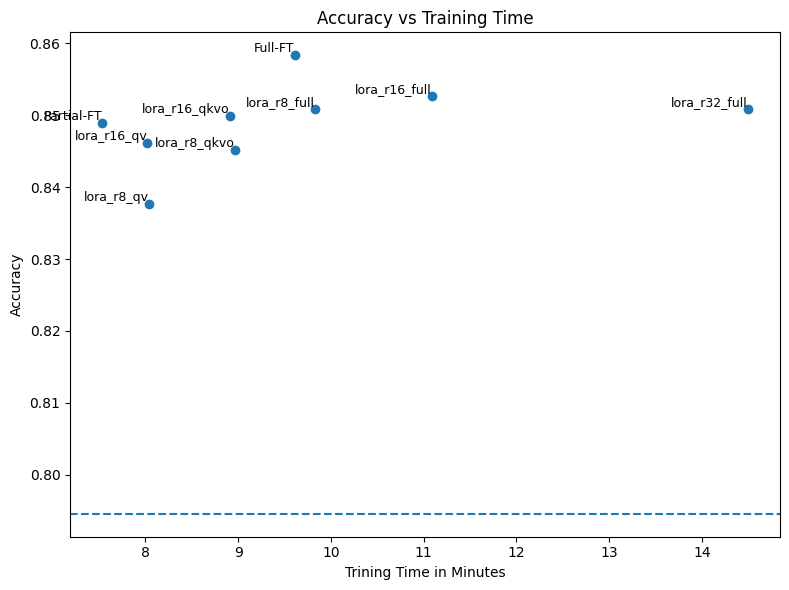

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_results["train_time_min"], df_results["eval_accuracy"])
plt.xlabel("Trining Time in Minutes")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Training Time")

# Add horizontal baseline line
plt.axhline(y=baseline_test_accuracy, linestyle='--')

# Annotate each point with model name
for idx, row in df_results.iterrows():
    plt.text(row["train_time_min"], row["eval_accuracy"], idx, fontsize=9, ha='right', va='bottom')

# Set y-axis to [0, 1]
#plt.ylim(0.8, 1)

plt.tight_layout()
plt.show()


#### Observations
DistilBERT is a relatively small model, and Rotten Tomatoes is a relatively small dataset. For this reason, the LoRA method does not show a clear advantage in this setting. Although the number of fine-tuned parameters is significantly lower, this reduction does not translate into a robust training-time advantage for the current setup. In fact, full fine-tuning is faster than some of the heavier LoRA configurations while also achieving the best performance.

Interestingly, partial fine-tuning is the fastest approach, despite not having the lowest number of trainable parameters. All models were trained for the same number of epochs (10), and each configuration appears to converge during training. Additional and more detailed training curves and considerations are available in my Weights & Biases report.


### Observing the Advantage of LoRA
The DistilBERT model and the Rotten Tomatoes dataset are too small to clearly demonstrate the advantages of LoRA. To attempt to better showcase its benefits over standard fine-tuning, the experiments are repeated using BERT-Base on the IMDB dataset.

In [34]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [35]:
from datasets import load_dataset
from transformers import AutoTokenizer

dataset = load_dataset("imdb")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_fn(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

# Create validation split (10% of train)
dataset = dataset["train"].train_test_split(test_size=0.1, seed=42)

# Rename for clarity
dataset = {
    "train": dataset["train"],
    "validation": dataset["test"],
    "test": load_dataset("imdb")["test"]
}
dataset

{'train': Dataset({
     features: ['text', 'label'],
     num_rows: 22500
 }),
 'validation': Dataset({
     features: ['text', 'label'],
     num_rows: 2500
 }),
 'test': Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 })}

In [36]:
tokenized_datasets = {}
for split in ["train", "validation", "test"]:
    tokenized = dataset[split].map(tokenize_fn, batched=True)
    tokenized = tokenized.remove_columns(["text"])
    tokenized = tokenized.rename_column("label", "labels")
    tokenized.set_format("torch")
    tokenized_datasets[split] = tokenized
tokenized_datasets

{'train': Dataset({
     features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 22500
 }),
 'validation': Dataset({
     features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 2500
 }),
 'test': Dataset({
     features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 25000
 })}

### Establishing a Stable Baseline

In [37]:
from transformers import pipeline
import numpy as np

# Create a feature extraction pipeline
feature_extractor = pipeline("feature-extraction", model="bert-base-uncased",truncation=True,padding=True,
    max_length=512, device=0 if torch.cuda.is_available() else -1)

Device set to use cuda:0


In [ ]:
# Define a function to extract CLS token embeddings
def extract_cls_embedding(batch):
    # The pipeline returns a list of lists of lists (batch, sequence, embedding)
    # We want the embedding of the first token ([CLS]) for each example in the batch
    features = feature_extractor(batch["text"])
    # Extract the [CLS] token embedding (index 0) from the last layer
    cls_embeddings = [np.array(f[0][0]) for f in features]
    return {"cls_embedding": cls_embeddings}

In [40]:
# Apply the feature extraction function to each split
# Use batched=True for efficiency
train_dataset_with_features = dataset["train"].map(extract_cls_embedding, batched=True, batch_size=16)
validation_dataset_with_features = dataset["validation"].map(extract_cls_embedding, batched=True, batch_size=16)
test_dataset_with_features = dataset["test"].map(extract_cls_embedding, batched=True, batch_size=16)
print("\nTrain dataset with CLS embeddings:")
print(train_dataset_with_features[0])

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map: 100%|██████████| 25000/25000 [19:51<00:00, 20.97 examples/s]


Train dataset with CLS embeddings:
{'text': "With these people faking so many shots, using old footage, and gassing animals to get them out, not to mention that some of the scenes were filmed on a created set with actors, what's to believe? Old film of countries is nice, but the animal abuse and degradation of natives is painful to watch in these films. I know, racism is OK in these old films, but there is more to that to make this couple lose credibility. Portrayed as fliers, they never flew their planes, Martin Johnson was an ex-vaudevillian, used friends like Jack London for financial gain while stiffing them of royalties, denying his wife's apparent depression, using her as a cute prop, all this makes these films unbearable. They were by no means the first to travel to these lands, or the first to write about them. He was OK as a filmmaker and photographer, but that's about it.", 'label': 0, 'cls_embedding': [0.014261935837566853, 0.5598693490028381, -0.22763265669345856, -0.20059

In [41]:
X_train = np.array(train_dataset_with_features["cls_embedding"])
y_train = np.array(train_dataset_with_features["label"])

X_val = np.array(validation_dataset_with_features["cls_embedding"])
y_val = np.array(validation_dataset_with_features["label"])

X_test = np.array(test_dataset_with_features["cls_embedding"])
y_test = np.array(test_dataset_with_features["label"])

# Print the shapes of the resulting NumPy arrays
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (22500, 768)
Shape of y_train: (22500,)
Shape of X_val: (2500, 768)
Shape of y_val: (2500,)
Shape of X_test: (25000, 768)
Shape of y_test: (25000,)


In [42]:
from sklearn.svm import SVC

# Instantiate the SVC classifier with default parameters
svm_classifier = SVC()

# Train the classifier using the training data
svm_classifier.fit(X_train, y_train)

print("SVM classifier training complete.")

SVM classifier training complete.


In [43]:
from sklearn.metrics import accuracy_score

wandb.init(project="Lab-3", name="imdb_bert_base_baseline_svm")

# Make predictions on the validation set
y_val_pred = svm_classifier.predict(X_val)

# Calculate accuracy on the validation set
validation_accuracy = accuracy_score(y_val, y_val_pred)

# Make predictions on the test set
y_test_pred = svm_classifier.predict(X_test)

# Calculate accuracy on the test set
baseline_test_accuracytest_accuracy = accuracy_score(y_test, y_test_pred)

# Print the accuracies
print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Test Accuracy: {baseline_test_accuracy:.4f}")
wandb.log({
    "baseline/validation_accuracy": validation_accuracy,
    "baseline/test_accuracy": baseline_test_accuracy,
})
wandb.finish()

Validation Accuracy: 0.8680
Test Accuracy: 0.7946


baseline/test_accuracy,▁
baseline/validation_accuracy,▁
baseline/test_accuracy,0.79456
baseline/validation_accuracy,0.868


### Fine-Tuning

#### Full Fine-Tuning

In [ ]:
from transformers import AutoModelForSequenceClassification

model_full = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

wandb.init(project="Lab-3", name="Bert-Base Full Fine-Tuning")
trainer_full = get_trainer(model_full, run_name="bert_full_finetune")
start = time.time()
trainer_full.train()
end = time.time()
metrics_full = trainer_full.evaluate()
metrics_full["trainable_params"] = count_trainable_params(model_full)
metrics_full["train_time_sec"] = end - start
metrics_full["train_time_min"] = (end - start) / 60
wandb.log({
    "test/accuracy": metrics_full["eval_accuracy"],
    "test/trainable_params": metrics_full["trainable_params"],
    "test/log_10_trainable_params": np.log10(metrics_full["trainable_params"]),
    "test/train_time_min": metrics_full["train_time_min"],
})
wandb.finish()

#### Partial Fine-Tuning

In [ ]:
from transformers import AutoModelForSequenceClassification

model_partial = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Freeze all backbone
for name, param in model_partial.named_parameters():
    param.requires_grad = False

# Unfreeze last encoder layer (layer 11, zero-indexed)
for param in model_partial.bert.encoder.layer[-1].parameters():
    param.requires_grad = True

# Keep classifier trainable
for param in model_partial.classifier.parameters():
    param.requires_grad = True

wandb.init(project="Lab-3", name="Bert-Base Partial Fine-Tuning")
trainer_partial = get_trainer(model_partial, run_name="bert_partial_finetune")
start = time.time()
trainer_partial.train()
end = time.time()
metrics_partial = trainer_partial.evaluate()
metrics_partial["trainable_params"] = count_trainable_params(model_partial)
metrics_partial["train_time_sec"] = end - start
metrics_partial["train_time_min"] = (end - start) / 60
wandb.log({
    "test/accuracy": metrics_partial["eval_accuracy"],
    "test/trainable_params": metrics_partial["trainable_params"],
    "test/log_10_trainable_params": np.log10(metrics_partial["trainable_params"]),
    "test/train_time_min": metrics_partial["train_time_min"],
})
wandb.finish()


#### LoRA Fine-Tuning
Since each training run is more time-intensive in this experiment, fewer LoRA configurations are selected, focusing on those that showed the most promising results in the DistilBERT experiments.

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType

lora_results = {}
lora_configs = {
    "lora_r8_full": {
        "r": 8,
        "alpha": 16,
        "dropout": 0.1,
        "target_modules":[
        "query", 
        "key", 
        "value",
        "output.dense"             
        ],
    },
    "lora_r16_qkv": {
        "r": 16,
        "alpha": 32,
        "dropout": 0.1,
        "target_modules":[
        "query", 
        "key", 
        "value"
        ],
    },
    "lora_r16_full": {
        "r": 16,
        "alpha": 32,
        "dropout": 0.1,
        "target_modules":[
        "query", 
        "key", 
        "value",
        "output.dense"             
        ],
    },
    "lora_r32_full": {
        "r": 32,
        "alpha": 64,
        "dropout": 0.15,
        "target_modules":[
        "query", 
        "key", 
        "value",
        "output.dense"             
        ],
    },
}

for name, cfg in lora_configs.items():

    base_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

    lora_config = LoraConfig(
        r=cfg["r"],
        lora_alpha=cfg["alpha"],
        lora_dropout=cfg["dropout"],
        bias="none",
        task_type=TaskType.SEQ_CLS,
        target_modules=cfg["target_modules"]
    )

    model_lora = get_peft_model(base_model, lora_config)

    wandb.init(project="Lab-3", name=f"Bert-Base {name} LoRA Fine-Tuning")
    trainer = get_trainer(model_lora, name)
    start = time.time()
    trainer.train()
    end = time.time()

    metrics = trainer.evaluate()
    metrics["trainable_params"] = count_trainable_params(model_lora)
    metrics["train_time_sec"] = end - start
    metrics["train_time_min"] = (end - start) / 60
    wandb.log({
    "test/accuracy": metrics["eval_accuracy"],
    "test/trainable_params": metrics["trainable_params"],
    "test/log_10_trainable_params": np.log10(metrics["trainable_params"]),
    "test/train_time_min": metrics["train_time_min"],
})

    lora_results[name] = metrics


In [ ]:
import pandas as pd

df_results = pd.DataFrame({
    "Full-FT": metrics_full,
    "Partial_FT": metrics_partial,
    **lora_results
})
# Transpose so models are rows
df_results = df_results.T

# Now compute log10
df_results["log10_trainable_params"] = np.log10(df_results["trainable_params"])

# Reorder columns if needed
df_results = df_results[["eval_accuracy", "eval_loss", "train_time_min", "trainable_params", "log10_trainable_params"]]

df_results

,eval_accuracy,eval_loss,train_time_min,trainable_params,log10_trainable_params
Full-FT,0.9208,0.576605,57.445291,109483778.0,8.039350
Partial_FT,0.9044,0.293383,35.148769,7089410.0,6.850610
lora_r8_full,0.9096,0.245288,52.388900,960002.0,5.982272
lora_r16_qkv,0.9084,0.251386,48.850404,886274.0,5.947568
lora_r16_full,0.9108,0.253232,52.531714,1918466.0,6.282954
lora_r32_full,0.9180,0.266095,53.181487,3835394.0,6.583810


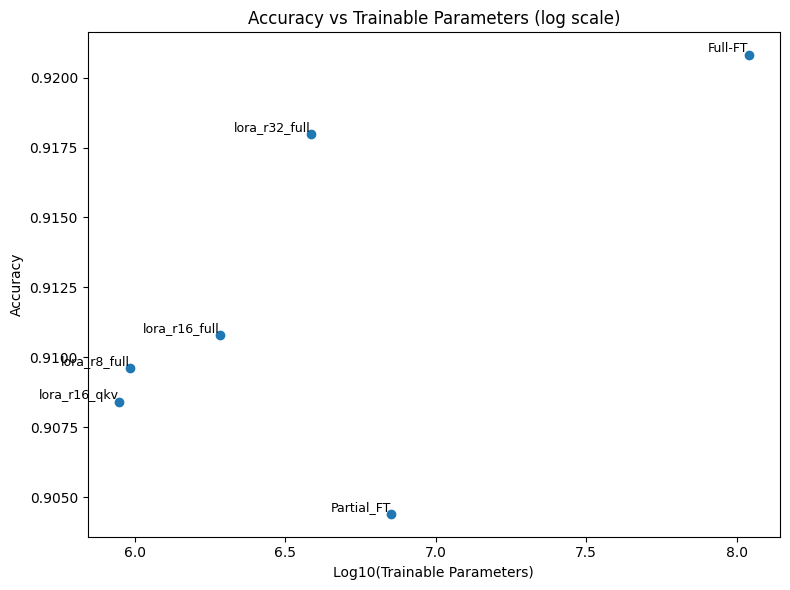

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_results["log10_trainable_params"], df_results["eval_accuracy"])
plt.xlabel("Log10(Trainable Parameters)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Trainable Parameters (log scale)")

# Add horizontal baseline line
#plt.axhline(y=baseline_test_accuracy, linestyle='--')

# Annotate each point with model name
for idx, row in df_results.iterrows():
    plt.text(row["log10_trainable_params"], row["eval_accuracy"], idx, fontsize=9, ha='right', va='bottom')

# Set y-axis to [0, 1]
#plt.ylim(0.8, 1)

plt.tight_layout()
plt.show()


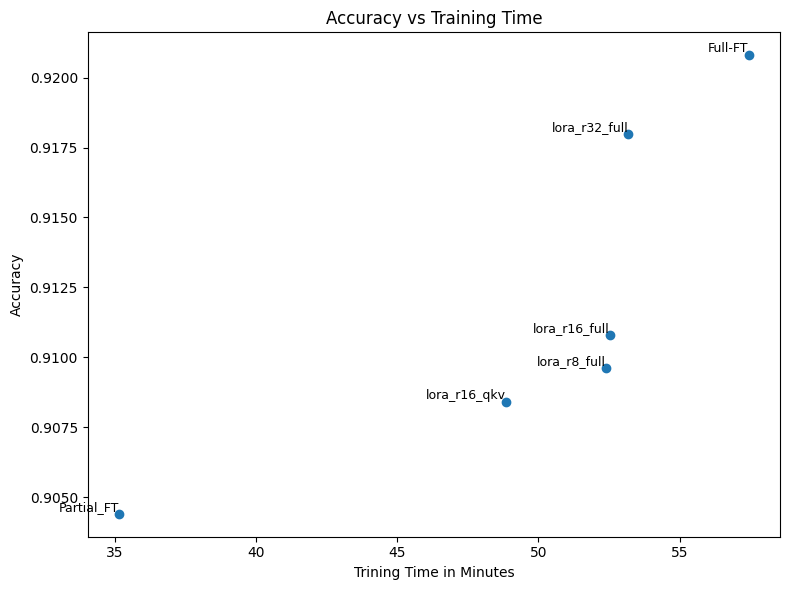

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_results["train_time_min"], df_results["eval_accuracy"])
plt.xlabel("Trining Time in Minutes")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Training Time")

# Add horizontal baseline line
#plt.axhline(y=baseline_test_accuracy, linestyle='--')

# Annotate each point with model name
for idx, row in df_results.iterrows():
    plt.text(row["train_time_min"], row["eval_accuracy"], idx, fontsize=9, ha='right', va='bottom')

# Set y-axis to [0, 1]
#plt.ylim(0.8, 1)

plt.tight_layout()
plt.show()


#### Observations
This experiment more clearly highlights the expected behavior. The LoRA method reduces fine-tuning cost and achieves better performance than partial fine-tuning. In particular, the rank-32 LoRA configuration is comparable to full fine-tuning in terms of accuracy, while still providing a modest—though not extraordinary—advantage in training time.

Partial fine-tuning, despite yielding the lowest performance, sacrifices only around one and a half percentage points in accuracy while nearly halving the training time.

#### Exercise 3.2: Fine-tuning a CLIP Model (harder)

Use a (small) CLIP model like [`openai/clip-vit-base-patch16`](https://huggingface.co/openai/clip-vit-base-patch16) and evaluate its zero-shot performance on a small image classification dataset like ImageNette or TinyImageNet. Fine-tune (using a parameter-efficient method!) the CLIP model to see how much improvement you can squeeze out of it.

**Note**: There are several ways to adapt the CLIP model; you could fine-tune the image encoder, the text encoder, or both. Or, you could experiment with prompt learning.

**Tip**: CLIP probably already works very well on ImageNet and ImageNet-like images. For extra fun, look for an image classification dataset with different image types (e.g. *sketches*).

In [ ]:
# Your code here.

#### Exercise 3.3: Choose your Own Adventure

There are a *ton* of interesting and fun models on the HuggingFace hub. Pick one that does something interesting and adapt it in some way to a new task. Or, combine two or more models into something more interesting or fun. The sky's the limit.

**Note**: Reach out to me by email or on the Discord if you are unsure about anything.

In [ ]:
# Your code here.